In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from deepsensor.data import DataProcessor, TaskLoader
from deepsensor.model import ConvNP
from deepsensor.train import Trainer
from deepsensor.train import set_gpu_default_device

# Import custom modules
from deepsensor_greatlakes.dataset_loader import (
    load_metadata, 
    load_glsea_data_combined, 
    load_context_data
)
from deepsensor_greatlakes.preprocessor import SeasonalCycleProcessor

/Users/dannes/deepsensor-greatlakes/deepsensor-greatlakes/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
# Load project metadata
metadata = load_metadata()

# Load context data
context_data = load_context_data(metadata)

# Load GLSEA data for specific years
glsea_ds = load_glsea_data_combined(metadata, years=[1995, 1996])

# Calculate seasonal cycle
seasonal_processor = SeasonalCycleProcessor()
seasonal_processor.calculate(glsea_ds)

# Compute anomalies
sst_anomalies = seasonal_processor.compute_anomalies(glsea_ds)

# Initialize DeepSensor DataProcessor
data_processor = DataProcessor(x1_name="lat", x2_name="lon")

# Normalize the anomalies
bathy_normalized, sst_normalized = data_processor([context_data['bathymetry'], sst_anomalies], method="min_max")


Loading context data:
Loading bathymetry

Bathymetry Validation:
Dimensions: 240 x 360
Depth range: 10.00m to 316.63m
Coverage: 23.0%
Loading lakemask

Lakemask Validation:
Dimensions: 838 x 1181
Values: [0. 1.]
Coverage: 100.0%
Loading glsea for 1995
Loading glsea for 1996

Combining GLSEA datasets...

GLSEA Data Validation:
Time range: 1995-01-01T00:00:00.000000000 to 1996-12-31T00:00:00.000000000
Spatial dimensions: 838 x 1181
SST range: 0.00°C to 29.49°C
Water coverage: 14.1%


In [3]:
context_data

{'bathymetry': <xarray.Dataset> Size: 696kB
 Dimensions:                        (lon: 360, lat: 240)
 Coordinates:
   * lon                            (lon) float64 3kB -92.07 -92.03 ... -76.18
   * lat                            (lat) float64 2kB 41.39 41.42 ... 48.76 48.79
 Data variables:
     __xarray_dataarray_variable__  (lat, lon) float64 691kB nan nan ... nan nan,
 'lakemask': <xarray.Dataset> Size: 4MB
 Dimensions:  (lon: 1181, lat: 838)
 Coordinates:
   * lon      (lon) float64 9kB -92.42 -92.41 -92.39 ... -75.91 -75.9 -75.88
   * lat      (lat) float64 7kB 38.87 38.89 38.9 38.92 ... 50.58 50.59 50.61
 Data variables:
     mask     (lat, lon) float32 4MB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0}

In [48]:
print(data_processor)

DataProcessor with normalisation params:
{'__xarray_dataarray_variable__': {'method': 'min_max',
                                   'params': {'max': 316.62872313037894,
                                              'min': 9.999999999999998}},
 'coords': {'time': {'name': 'time'},
            'x1': {'map': (41.39390182495117, 57.28290939331055),
                   'name': 'lat'},
            'x2': {'map': (-92.07150268554688, -76.1824951171875),
                   'name': 'lon'}},
 'sst': {'method': 'min_max',
         'params': {'max': 18.38983154296875, 'min': -16.22322654724121}}}


In [46]:
context_data

{'bathymetry': <xarray.Dataset> Size: 696kB
 Dimensions:                        (lon: 360, lat: 240)
 Coordinates:
   * lon                            (lon) float64 3kB -92.07 -92.03 ... -76.18
   * lat                            (lat) float64 2kB 41.39 41.42 ... 48.76 48.79
 Data variables:
     __xarray_dataarray_variable__  (lat, lon) float64 691kB nan nan ... nan nan,
 'lakemask': <xarray.Dataset> Size: 4MB
 Dimensions:  (lon: 1181, lat: 838)
 Coordinates:
   * lon      (lon) float64 9kB -92.42 -92.41 -92.39 ... -75.91 -75.9 -75.88
   * lat      (lat) float64 7kB 38.87 38.89 38.9 38.92 ... 50.58 50.59 50.61
 Data variables:
     mask     (lat, lon) float32 4MB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0}

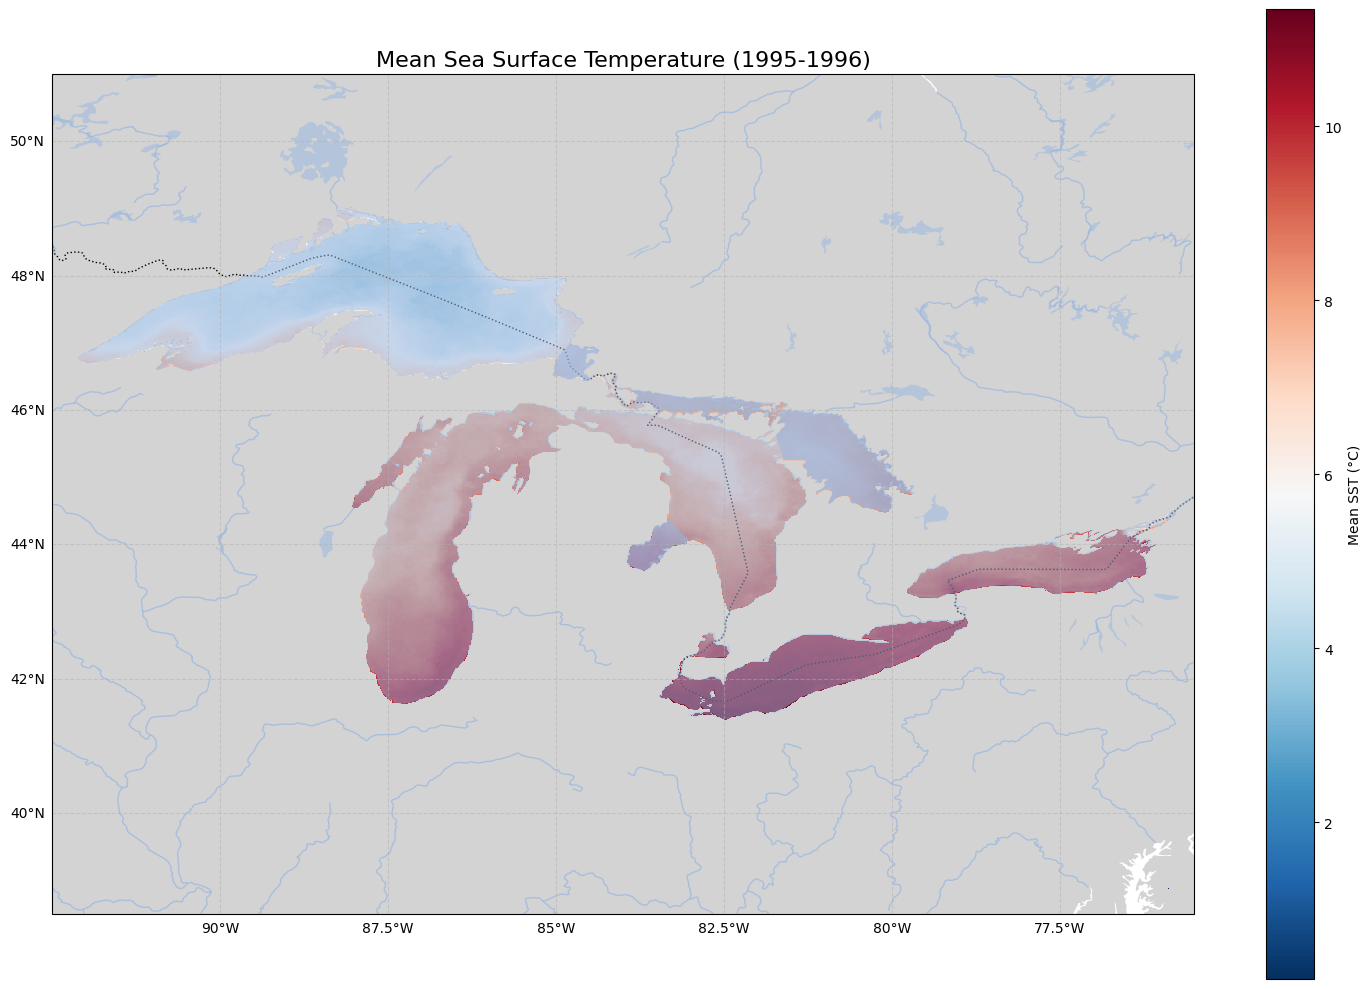

In [25]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Assuming 'sst' is the xarray.Dataset you provided
sst_mean = glsea_ds.mean(dim='time')  # Compute the mean SST over time

# Create figure and map projection
plt.figure(figsize=(15, 10))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.LAND, facecolor='lightgrey')
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS, linestyle='-', alpha=0.7)

# Plot the mean SST directly from the xarray dataset
im = sst_mean.sst.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap='RdBu_r',
    add_colorbar=False,  # We'll add a custom colorbar later
)

# Add a colorbar
plt.colorbar(im, ax=ax, label='Mean SST (°C)')

# Set the map extent to focus on the Great Lakes region
ax.set_extent([-92.5, -75.5, 38.5, 51], crs=ccrs.PlateCarree())

# Add gridlines for better reference
gl = ax.gridlines(draw_labels=True, linestyle='--', alpha=0.5)
gl.top_labels = False
gl.right_labels = False

# Add a title
plt.title('Mean Sea Surface Temperature (1995-1996)', fontsize=16)

# Adjust layout for better visualization
plt.tight_layout()

# Show the plot
plt.show()


In [29]:
# Optional: Save processors and seasonal cycle
#seasonal_processor.save("data/seasonal_cycles/glsea_1995_1996")
#data_processor.save("data/processors/glsea_sst_anomalies")

# Print some basic information
print("Data preprocessing and visualization complete.")
print(f"Normalized SST Anomaly Shape: {sst_normalized.sst.shape}")

Data preprocessing and visualization complete.
Normalized SST Anomaly Shape: (731, 838, 1181)
Latitude Range: 0.0 to 1.0
Longitude Range: 0.0 to 0.709322033898305


In [34]:
context_data

{'bathymetry': <xarray.Dataset> Size: 696kB
 Dimensions:                        (lon: 360, lat: 240)
 Coordinates:
   * lon                            (lon) float64 3kB -92.07 -92.03 ... -76.18
   * lat                            (lat) float64 2kB 41.39 41.42 ... 48.76 48.79
 Data variables:
     __xarray_dataarray_variable__  (lat, lon) float64 691kB nan nan ... nan nan,
 'lakemask': <xarray.Dataset> Size: 4MB
 Dimensions:  (lon: 1181, lat: 838)
 Coordinates:
   * lon      (lon) float64 9kB -92.42 -92.41 -92.39 ... -75.91 -75.9 -75.88
   * lat      (lat) float64 7kB 38.87 38.89 38.9 38.92 ... 50.58 50.59 50.61
 Data variables:
     mask     (lat, lon) float32 4MB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0}